# Data
## EDA
### Projects

In [1]:
from collections import Counter
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen

In [2]:
# Load projects
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.json"
projects = json.loads(urlopen(url).read())
print (f"{len(projects)} projects")
print (json.dumps(projects[0], indent=2))

955 projects
{
  "id": 6,
  "created_on": "2020-02-20 06:43:18",
  "title": "Comparison between YOLO and RCNN on real world videos",
  "description": "Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.",
  "tag": "computer-vision"
}


In [3]:
# Create dataframe
df = pd.DataFrame(projects)
print (f"{len(df)} projects")
df.head(5)

955 projects


id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description                     tag  
0  Bringing theory to experiment is cool. We can ...         computer-vision  
1  The beauty of the work lies in the way it arch...         computer-vision  
2  A collection of important graph embedding, cla...          graph-learning  
3  A curated list of Monte Carlo tree search pape...  reinforcement-learning  
4  Reference implementation of Diffusion2Vec (Com...          graph-learning

In [4]:
# 1. remove projects with no tag
df = df[df.tag.notnull()]

In [5]:
# 2. Most common tags
tags = Counter(df.tag.values)
tags.most_common()

[('natural-language-processing', 388),
 ('computer-vision', 356),
 ('mlops', 79),
 ('reinforcement-learning', 56),
 ('graph-learning', 45),
 ('time-series', 31)]

### Tags

In [6]:
# Load tags
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.json"
tags_dict = {}
for item in json.loads(urlopen(url).read()):
    key = item.pop("tag")
    tags_dict[key] = item
print (f"{len(tags_dict)} tags")


4 tags


In [7]:
@widgets.interact(tag=list(tags_dict.keys()))
def display_tag_details(tag="computer-vision"):
    print (json.dumps(tags_dict[tag], indent=2))


interactive(children=(Dropdown(description='tag', options=('computer-vision', 'graph-learning', 'mlops', 'natu…

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

### Tag Distribution

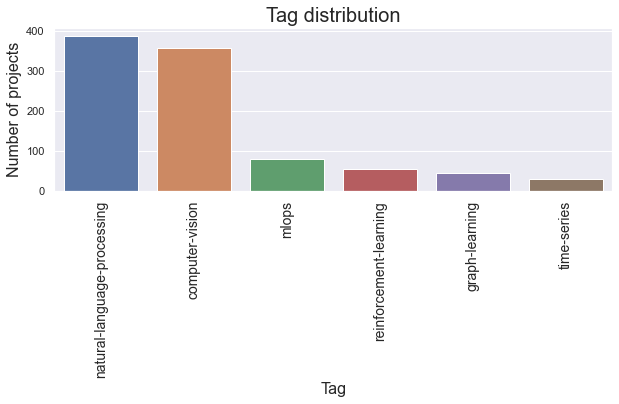

In [9]:
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(list(tags), list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

### Wordcloud

In [10]:
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing", column_name = 'title'):
    plt.figure(figsize=(15, 5))
    subset = df[df.tag == tag]
    text = subset[column_name].values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)
    

interactive(children=(Dropdown(description='tag', options=('natural-language-processing', 'computer-vision', '…

## Data Labeling
- if a data point has a tag that we currently don't support, we'll replace it with `other`
- if a certain tag doesn't have enough samples, we'll replace it with `other`

In [11]:
# Out of scope (OOS) tags 
oos_tags = [item for item in df.tag.unique() if item not in tags_dict.keys()]
oos_tags

['reinforcement-learning', 'time-series']

In [12]:
oos_indices = df[df.tag.isin(oos_tags)].index
df.iloc[oos_indices].head()

id           created_on                                       title  \
3    15  2020-02-28 23:55:26             Awesome Monte Carlo Tree Search   
37  121  2020-03-24 04:56:38  Deep Reinforcement Learning in TensorFlow2   
67  218  2020-04-06 11:29:57         Distributional RL using TensorFlow2   
74  239  2020-04-06 18:39:48               Prophet: Forecasting At Scale   
95  277  2020-04-07 00:30:33       Curriculum for Reinforcement Learning   

                                          description                     tag  
3   A curated list of Monte Carlo tree search pape...  reinforcement-learning  
37  deep-rl-tf2 is a repository that implements a ...  reinforcement-learning  
67  🐳 Implementation of various Distributional Rei...  reinforcement-learning  
74  Tool for producing high quality forecasts for ...             time-series  
95  Curriculum learning applied to reinforcement l...  reinforcement-learning

In [13]:
df.loc[oos_indices, ['tag']] = ["other"]

In [14]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...   graph-learning  
3  A curated list of Monte Carlo tree search pape...            other  
4  Reference implementation of Diffusion2Vec (Com...   graph-learning

In [15]:
min_freq = 75
tags = Counter(df.tag.values)
print(tags)

Counter({'natural-language-processing': 388, 'computer-vision': 356, 'other': 87, 'mlops': 79, 'graph-learning': 45})


In [16]:
@widgets.interact(min_freq=(0, tags.most_common()[0][1]+1))
def separate_tags_by_feq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements() if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements() if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

interactive(children=(IntSlider(value=75, description='min_freq', max=389), Output()), _dom_classes=('widget-i…

In [17]:
def filter(tag, include=[]):
    """Determine if a given tag is to be included

    Args:
        tag (_type_): _description_
        include (list, optional): _description_. Defaults to [].
    """    
    if tag in include:
        return tag

In [18]:
tags_above_freq = Counter(tag for tag in tags.elements() if tags[tag] >= min_freq)
df.tag = df.tag.apply(filter, include=list(tags_above_freq.keys()))

In [19]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...             None  
3  A curated list of Monte Carlo tree search pape...            other  
4  Reference implementation of Diffusion2Vec (Com...             None

In [20]:
df.tag = df.tag.fillna("other")

In [79]:
# Save labeled data
with open("labeled_projects.json", "w") as fp:
    json.dump(df.to_dict(orient="records"), indent=2, fp=fp)


In [21]:
from snorkel.labeling import labeling_function

@labeling_function()
def contains_tensorflow(text):
    condition = any(tag in text.lower() for tag in ("tensorflow", "tf"))
    return "tensorflow" if condition else None

## Preprocessing

### Feature engineering

In [22]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  
0  Bringing theory to experiment is cool. We can ...  computer-vision  
1  The beauty of the work lies in the way it arch...  computer-vision  
2  A collection of important graph embedding, cla...            other  
3  A curated list of Monte Carlo tree search pape...            other  
4  Reference implementation of Diffusion2Vec (Com...            other

In [23]:
df['text'] = df.title + " " + df.description

In [24]:
df.head()

id           created_on                                              title  \
0   6  2020-02-20 06:43:18  Comparison between YOLO and RCNN on real world...   
1   7  2020-02-20 06:47:21  Show, Infer & Tell: Contextual Inference for C...   
2   9  2020-02-24 16:24:45                       Awesome Graph Classification   
3  15  2020-02-28 23:55:26                    Awesome Monte Carlo Tree Search   
4  19  2020-03-03 13:54:31                                Diffusion to Vector   

                                         description              tag  \
0  Bringing theory to experiment is cool. We can ...  computer-vision   
1  The beauty of the work lies in the way it arch...  computer-vision   
2  A collection of important graph embedding, cla...            other   
3  A curated list of Monte Carlo tree search pape...            other   
4  Reference implementation of Diffusion2Vec (Com...            other   

                                                text  
0  Comparison between YOLO and RCNN on real world...  
1  Show, Infer & Tell: Contextual Inference for C...  
2  Awesome Graph Classification A collection of i...  
3  Awesome Monte Carlo Tree Search A curated list...  
4  Diffusion to Vector Reference implementation o...

### Cleaning

In [25]:
%pip install nltk==3.7 -q

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python38\python.exe -m pip install --upgrade pip' command.


In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [27]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text, lower text, remove stopwords, remove punctuations, non alphanumeric chars, multiple consecutive white spaces, finally stem words

    Args:
        text (str): _description_
        lower (bool, optional): _description_. Defaults to True.
        stem (bool, optional): _description_. Defaults to False.
        stopwords (_type_, optional): _description_. Defaults to STOPWORDS.
    """
    if lower:
        text = text.lower()

    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        # NOTE: above regex \b... searches for "..." at the beginning of a word
        # "...\b" searches for "..." at the end of a word
        # "\s" searches for whitespace characters
        # "*" searches for zero or more occurrences of preceeding text
        text = pattern.sub('', text)
    
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars, "[^...]" - not containing "..."
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])
    
    return text

In [29]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs. 12 #$  ! @.fv ronb wo2in3r"
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)    

interactive(children=(Checkbox(value=True, description='lower'), Checkbox(value=False, description='stem'), Ou…

In [30]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")


Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


### Encoding

In [31]:
import numpy as np
import random


In [32]:
df.tag.unique()

array(['computer-vision', 'other', 'natural-language-processing', 'mlops'],
      dtype=object)

In [33]:
X = df.text.to_numpy()
y = df.tag

In [34]:
class LabelEncoder():
    """Encode target labels `y` into unique indices between `0` and `n_classes-1`.
    """
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {} # mutable defaults
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
    
    def __len__(self):
        return len(self.classes)
    
    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})"
    
    def fit(self, y):
        classes = np.unique(y)
        self.index_to_class = {}
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
            self.index_to_class[i] = class_
        self.classes = list(self.class_to_index.keys())
        return self
    
    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)
    
    @classmethod
    def load(cls, fp):
        # A class method is LIKE a static function?
        # A class method is a method which is bound to the class and not the object of the class.
        # They have the access to the state of the class as it takes a class parameter that points to the class and not the object instance.
        # It can modify a class state that would apply across all the instances of the class. For example, it can modify a class variable that would be applicable to all the instances.
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

    

In [35]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)


In [36]:
label_encoder.class_to_index


{'computer-vision': 0,
 'mlops': 1,
 'natural-language-processing': 2,
 'other': 3}

In [37]:
label_encoder.index_to_class


{0: 'computer-vision',
 1: 'mlops',
 2: 'natural-language-processing',
 3: 'other'}

In [38]:
# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])


array([0, 1, 1])

In [39]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))


['computer-vision', 'mlops', 'mlops']

In [40]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)


(955,)


## Splitting

**What are the criteria we should focus on to ensure proper data splits?**
- the dataset (and each data split) should be representative of data we will encounter
- equal distributions of output values across all splits
- shuffle your data if it's organized in a way that prevents input variance
- avoid random shuffles if your task can suffer from data leaks (ex. time-series)

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15


In [43]:
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, stratify=y)

In [44]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")


train: 668 (0.70)
remaining: 287 (0.30)


In [45]:
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=(test_size/(test_size+val_size)), stratify=y_)

In [46]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")


train: 668 (0.70)
val: 143 (0.15)
test: 144 (0.15)


In [47]:
# Get counts for each class
counts = {}
counts["train_counts"] = Counter(label_encoder.decode(y_train))
counts["val_counts"] = Counter(label_encoder.decode(y_val))
counts["test_counts"] = Counter(label_encoder.decode(y_test))


In [48]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

computer-vision  other  mlops  natural-language-processing
train              249     92     55                          272
val                 53     20     12                           58
test                54     20     12                           58

In [49]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))


In [50]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df


computer-vision  other  mlops  natural-language-processing
train              249     92     55                          272
val                247     93     56                          270
test               252     93     56                          270

In [51]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))


0.9851056877051132

In [52]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

text              tag
0  semantic segmentation mit ade20k dataset pytor...  computer-vision
1  model based reinforcement learning survey surv...            other
2  serving pytorch models production amazon sagem...            mlops
3  super bpd fast image segmentation propose dire...  computer-vision
4  pixellib pixellib library performing segmentat...  computer-vision

## Augmentation
We'll often want to increase the size and diversity of our training data split through data augmentation. It involves using the existing samples to generate synthetic, yet realistic, examples.

1. Split the dataset. We want to split our dataset first because many augmentation techniques will cause a form of data leak if we allow the generated samples to be placed across different data splits.

>For example, some augmentation involves generating synonyms for certain key tokens in a sentence. If we allow the generated sentences from the same origin sentence to go into different splits, we could be potentially leaking samples with nearly identical embedding representations across our different splits.

2. Augment the training split. We want to apply data augmentation on only the training set because our validation and testing splits should be used to provide an accurate estimate on actual data points.

3. Inspect and validate. It's useless to augment just for the same of increasing our training sample size if the augmented data samples are not probable inputs that our model could encounter in production.

In [53]:
!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.8 -q


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\soham\\AppData\\Roaming\\Python\\Python38\\site-packages\\~klearn\\.libs\\vcomp140.dll'
Check the permissions.

You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [54]:
import nlpaug.augmenter.word as naw

In [55]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='substitute')
insertion = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='insert')
text = "Conditional image generation using Variational Autoencoders and GANs."


In [56]:
# Substitutions
substitution.augment(text)


'quantum image generation utilizes naive algorithms and gans.'

Substitution doesn't seem like a great idea for us because there are certain keywords that provide strong signal for our tags so we don't want to alter those. Also, note that these augmentations are NOT deterministic and will vary every time we run them. Let's try insertion...

In [57]:
# Insertions
insertion.augment(text)


'conditional linear image generation technique using variational conditional autoencoders and input gans.'

A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear. Maybe instead of substituting or inserting new tokens, let's try simply swapping machine learning related keywords with their aliases from our auxiliary data. We'll use Snorkel's transformation functions to easily achieve this.

In [58]:
def replace_dash(x):
    """Replace dashes from tags & aliases

    Args:
        x (str): _description_
    """
    return x.replace("-", " ")
    

In [59]:
# Create dict of aliases
flat_tags_dict = {}
for tag, info in tags_dict.items():
    tag = replace_dash(x=tag)
    aliases = list(map(replace_dash, info['aliases']))
    if len(aliases):
        flat_tags_dict[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flat_tags_dict[alias] = _aliases

In [60]:
print (flat_tags_dict["natural language processing"])
print (flat_tags_dict["nlp"])


['nlp', 'nlproc']
['nlproc', 'natural language processing']


In [61]:
flat_tags_dict

{'computer vision': ['cv', 'vision'],
 'cv': ['vision', 'computer vision'],
 'vision': ['cv', 'computer vision'],
 'graph learning': ['graphs'],
 'graphs': ['graph learning'],
 'mlops': ['production'],
 'production': ['mlops'],
 'natural language processing': ['nlp', 'nlproc'],
 'nlp': ['nlproc', 'natural language processing'],
 'nlproc': ['nlp', 'natural language processing']}

In [62]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")


True
True


In [63]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)


In [64]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))


<re.Match object; span=(10, 13), match='gan'>
None


In [65]:
from snorkel.augmentation import transformation_function

In [66]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.

    Args:
        x (_type_): _description_
    """
    matches = []
    text = x.text
    for i, tag in enumerate(flat_tags_dict):
        match = find_word(tag, text)
        if match:
            matches.append(match)
    if len(matches):
        match = random.choice(matches)
        tag = text[match.start():match.end()]
        x.text = f"{text[:match.start()]}{random.choice(flat_tags_dict[tag])}{text[match.end():]}"
    return x

In [67]:
# Swap
sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
for i in range(3):
    print(swap_aliases(sample_df.copy().iloc[0]).text)


survey reinforcement learning natural language processing tasks
survey reinforcement learning nlproc tasks
survey reinforcement learning nlproc tasks


In [68]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)


autogenerate vision apply jobs using nlp
autogenerate vision apply jobs using nlp
autogenerate vision apply jobs using nlp


In [69]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [70]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=['text'], inplace=True)
train_df_augmented.head()

100%|██████████| 668/668 [00:01<00:00, 412.25it/s]


text              tag
0  semantic segmentation mit ade20k dataset pytor...  computer-vision
1  model based reinforcement learning survey surv...            other
2  serving pytorch models production amazon sagem...            mlops
2  serving pytorch models mlops amazon sagemaker ...            mlops
3  super bpd fast image segmentation propose dire...  computer-vision

In [71]:
len(train_df), len(train_df_augmented)

(668, 919)

# Modeling
## Baselines

In [72]:
import random

In [73]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)


In [74]:
def preprocess(df, lower, stem):
    """Preprocess the data

    Args:
        df (pandas.DataFrame): _description_
        lower (bool): _description_
        stem (bool): _description_
    """
    df['text'] = df.title + " " + df.description
    df.text = df.text.apply(clean_text, lower=lower, stem=stem)
    return df    

In [75]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits

    Args:
        X (_type_): _description_
        y (_type_): _description_
        train_size (float, optional): _description_. Defaults to 0.7.
    """
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [77]:
df = df.sample(frac=1).reset_index(drop=True)  # shuffle
# df = df[:num_samples]


> **Why is it important that we shuffle our dataset?**
>>We need to shuffle our data since our data is chronologically organized. The latest projects may have certain features or tags that are prevalent compared to earlier projects. If we don't shuffle before creating our data splits, then our model will only be trained on the earlier signals and fail to generalize. However, in other scenarios (ex. time-series forecasting), shuffling will lead do data leaks. 



### Random

In [78]:
from sklearn.metrics import precision_recall_fscore_support

In [80]:
# Setup
set_seeds()
df = pd.DataFrame(json.load(open("labeled_projects.json", "r")))
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [82]:
# Label encoder
print (label_encoder)
print (label_encoder.class_to_index)

<LabelEncoder(num_classes=4)
{'computer-vision': 0, 'mlops': 1, 'natural-language-processing': 2, 'other': 3}


In [85]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print (y_pred.shape)
print (y_pred[0:5])

(144,)
[2 2 1 3 1]


In [87]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.29428010261343596,
  "recall": 0.2152777777777778,
  "f1": 0.2378460375525673
}


We made the assumption when making predictions that there is an equal probability for every class. Let's use the train split to figure out what the true probability is.

In [88]:
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]
p

[0.375, 0.08333333333333333, 0.4027777777777778, 0.1388888888888889]

In [89]:
# Generate weighted random predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

In [90]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))


{
  "precision": 0.2589471067442853,
  "recall": 0.2708333333333333,
  "f1": 0.26341520404853686
}


<u>limitations:</u> we didn't use the tokens in our input to affect our predictions **so nothing was learned**

### Rule Based

<u>motivation:</u> we want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

In [91]:
# Setup
set_seeds()
df = pd.DataFrame(json.load(open("labeled_projects.json", "r")))
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))


In [95]:
label_encoder.classes

['computer-vision', 'mlops', 'natural-language-processing', 'other']

In [96]:
print(len(tags_dict))
tags_dict = {tag: tags_dict[tag] for tag in label_encoder.classes if tag != "other"}
print(len(tags_dict))

4
3


In [100]:
# Map aliases
aliases = {}
for tag, values in tags_dict.items():
    aliases[clean_text(tag)] = tag
    for alias in values["aliases"]:
        aliases[clean_text(alias)] = tag
aliases

{'computer vision': 'computer-vision',
 'cv': 'computer-vision',
 'vision': 'computer-vision',
 'mlops': 'mlops',
 'production': 'mlops',
 'natural language processing': 'natural-language-processing',
 'nlp': 'natural-language-processing',
 'nlproc': 'natural-language-processing'}

In [101]:
def get_tag(text, aliases, tags_dict):
    """If a text token matches an alias then add/return the corresponing tag class

    Args:
        text (str): _description_
        aliases (_type_): _description_
        tags_dict (dict): _description_
    """
    for alias, tag in aliases.items():
        if alias in text:
            return tag
    return None

In [104]:
# Sample
text = "A pretrained model hub for popular nlp models."
print(get_tag(text=clean_text(text), aliases=aliases, tags_dict=tags_dict))

natural-language-processing


In [105]:
# Prediction
tags = []
for text in X_test:
    tag = get_tag(text, aliases, tags_dict)
    tags.append(tag)


In [106]:
# Encode labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]


In [107]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))


{
  "precision": 0.7777777777777778,
  "recall": 0.13194444444444445,
  "f1": 0.22560690943043882
}


**How come our precision is high but our recall is so low?**

Precision is high implies that most of the samples predicted as particular class are correct.

Low recall implies that the out of all the predictions made for an input of a particular class, the number of misclassifications is high OR in this case, particular aliases for tags might not be used in the input signals



In [108]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases=aliases, tags_dict=tags_dict))


None


<u><i>limitations:</i></u> we failed to generalize or learn any implicit patterns to predict the labels because we treat the tokens in our input as isolated entities.

### Vectorization

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [110]:
# Setup
set_seeds()
df = pd.DataFrame(json.load(open("labeled_projects.json", "r")))
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))


In [111]:
# Saving raw X_test to compare with later
X_test_raw = X_test


In [112]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train.shape)  # scipy.sparse.csr_matrix


identifying brain tumor mri images using fastai dynamicunet use fastai unet learner identify tumours mri brain logging loss metrics neptune ai logger compare results hyperparameter tuning
(668, 98624)


In [113]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")


class counts: [249  55 272  92],
class weights: {0: 0.004016064257028112, 1: 0.01818181818181818, 2: 0.003676470588235294, 3: 0.010869565217391304}


### Data Imbalance

In [115]:
!pip install imbalanced-learn==0.8.1 -q

You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [116]:
from imblearn.over_sampling import RandomOverSampler


In [117]:
oversample = RandomOverSampler(sampling_strategy='all') # resample all classes
X_over, y_over = oversample.fit_resample(X_train, y_train)

It's important that we applied sampling only on the train split so we don't introduce data leaks with the other data splits

In [121]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")


class counts: [272 272 272 272],
class weights: {0: 0.003676470588235294, 1: 0.003676470588235294, 2: 0.003676470588235294, 3: 0.003676470588235294}


### Machine Learning

In [123]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [124]:
model = SGDClassifier(loss='log', penalty='l2', alpha=1e-4, max_iter=1, learning_rate="constant", eta0=1e-1, power_t=0.1, warm_start=True)

In [125]:
num_epochs = 100
for epoch in range(num_epochs):
    model.fit(X_over, y_over)

    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch % 10:
        print(f"Epoch: {epoch:02d}",
              f"train_loss: {train_loss:0.5f}",
              f"val_loss: {val_loss:0.5f}",
              )


Epoch: 00 train_loss: 1.16565 val_loss: 1.19813
Epoch: 10 train_loss: 0.45728 val_loss: 0.60118
Epoch: 20 train_loss: 0.31276 val_loss: 0.49740
Epoch: 30 train_loss: 0.24955 val_loss: 0.45547
Epoch: 40 train_loss: 0.21508 val_loss: 0.43379
Epoch: 50 train_loss: 0.19405 val_loss: 0.42097
Epoch: 60 train_loss: 0.18030 val_loss: 0.41308
Epoch: 70 train_loss: 0.17113 val_loss: 0.40796
Epoch: 80 train_loss: 0.16461 val_loss: 0.40444
Epoch: 90 train_loss: 0.15992 val_loss: 0.40205


In [126]:
# Evaluate
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))


{
  "precision": 0.86339304503367,
  "recall": 0.8611111111111112,
  "f1": 0.8589332382988834
}


In [127]:
# Inference (with tokens similar to training data)
text = "Transfer learning with transformers for text classification."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)


['natural-language-processing']

In [128]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}


{'computer-vision': 0.03533671174343364,
 'mlops': 0.004866229433854612,
 'natural-language-processing': 0.9448683528892217,
 'other': 0.014928705933490098}

In [129]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)


['natural-language-processing']

In [130]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}


{'computer-vision': 0.12993126306387198,
 'mlops': 0.07849949603775445,
 'natural-language-processing': 0.6904508159758787,
 'other': 0.10111842492249486}

In [134]:
print(y_pred, y_prob)

[2] [[0.12993126 0.0784995  0.69045082 0.10111842]]


In [135]:

# Determine first quantile softmax score for the correct class (on validation split)
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)
threshold

0.6610073518702174

In [136]:
# Custom predict function
def custom_predict(y_prob, threshold, index):
    """Custom predict function that defaults
    to an index if conditions are not met."""
    y_pred = [np.argmax(p) if max(p) > threshold else index for p in y_prob]
    return np.array(y_pred)


In [137]:
def predict_tag(texts):
    y_prob = model.predict_proba(vectorizer.transform(texts))
    other_index = label_encoder.class_to_index["other"]
    y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)
    return label_encoder.decode(y_pred)


In [138]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
predict_tag(texts=[text])


['natural-language-processing']

In [140]:
# Evaluate
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=label_encoder.class_to_index["other"])
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))


{
  "precision": 0.8685798548094374,
  "recall": 0.7083333333333334,
  "f1": 0.7435471159850042
}
